# Response Themes for "What new features or changes would you like to see in Jupyter Notebook? (Please list anything that comes to mind that helps you in your workflow, big or small.)"

* Goal: Extract theme keywords from `features_changes` responses.
* Data: Output from 2_clean_survey.ipynb notebook (`survey_short_columns.csv`)
* Process from [1_ux_survey_review.ipynb](1_ux_survey_review.ipynb):

> Moving forward, here's a semi-automatic procedure we can follow for identifying themes across questions:
> 1. Take a random sample of question responses
> 2. Write down common theme keywords
> 3. Search back through the responses using the theme keywords
> 4. Expand the set of keywords with other words seen in the search results
> 5. Repeat for all themes and questions
> Later, we can use a fully automated topic modeling approach to validate our manually generated themes.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

Make sure the samples come up the same for anyone that re-runs this.

In [4]:
rs = np.random.RandomState(123)

In [5]:
pd.set_option('max_colwidth', 1000)

In [6]:
df = pd.read_csv('survey_short_columns.csv')

In [7]:
def show(series):
    '''Make random samples easier to read.'''
    for i, value in enumerate(series):
        print('{}) {}'.format(i, value), end='\n\n')

In [8]:
responses = pd.concat([df.features_changes_1, df.features_changes_2, df.features_changes_3], ignore_index=True)

In [9]:
assert len(responses) == len(df) * 3

In [10]:
responses.isnull().value_counts()

True     3972
False    1146
dtype: int64

In [11]:
responses = responses.dropna()

## Initial Samples

I ran the sampling code below multiple times and manually built up the initial set of keywords seen commonly across them. I formed groups of conceptually related keywords. Then I tried to assign a simple label to each group.

In [12]:
show(responses.sample(20, random_state=rs))

0) sort files in folders

1) Well-documented extensions framework

2) Easy (CSS) customization of basic settings (code block themes, fonts, etc.)

3) Debug capabilities / "Workspace explorer"

4) Drag and drop for cells

5) Tighter integration of qtconsole

6) Googling for IPython notebook issues turns up tons of legacy  solutions; what's the current right way?

7) Stylesheets configuration

8) External editor

9) Allow hiding of code blocks when rendering to html/md

10) Native wrapper for saving and opening

11) https://github.com/jupyter/notebook/issues/389#issuecomment-154087320

12) Brainless cloud developement

13) Export non-code elements (Markdown and plots)

14) Built-in compatibility with git

15) Easier access to text editing

16) drag/drop of cells

17) Web API documentation

18) metadata editing within the notebook

19) small: add  So I can run jupyter as a standalone app on android with the kernel running in a chroot environment.



In [128]:
themes = {
    'ux': ['drag', 'drop', 'stylesheets', 'CSS', 'theme', 'button', 'groups of cells', 'sections', 
           'individual cells', 'click', 'paste', 'color', 'undo', 'navigating', 'all cells', 'copy/paste', 
           'touch screen', 'width', 'height', 'todo', 'spell check', 'collapse cells', 'styles', 'scrolling', 
           'skin', 'collapsible', 'folding of cells', 'keyboard', 'icon', 'fold', 'folding', 'shortcuts', 
           'navigate', 'navigation', 'menus', 'shortcut', 'ui', 'collapse', 'collapsing', 'screen', 'hide cells',
           'hiding cells', 'key mappings', 'tooltips', 'multiple cells', 'mobile', 'progress bar', 'hotkey', 
           'code hiding', 'pane', 'window', 'moving cells', 'reordering cells', 'toggle', 'GUI', 'sidebar', 
           'spellchecker', 'spell-checker', 'dialog', ],
    'version_control': ['version control', 'git', 'version management', 'version tracking', 'version history',
                        'control version', 'not versioned', 'source control', 'version-controlled', 
                        'version notebooks', 'editing history', 'revisions/code', 'revisions', 'versioning', 
                        'change tracking', 'change tracker', ],
    'dashboards': ['hiding of code blocks', 'hide code cells', 'application deployment', 'hide input in slides',
                   'hide code', 'easily shareable interactive HTML/JS pages', 'interactive plotting', 
                   'report generation', 'dashboard', 'dashboards', 'presentation/slide mode', 'interactive plots',
                   'knitr', ],
    'documentation': ['documentation', 'not enough docs', 'docs', 'doc', 'tutorial', 'tutorials', 'instructions',
                      ],
    'ide': ['workspace', 'variable explorer', 'ide', 'debug', 'profiler', 'profiling', 'breakpoints', 
            'rstudio', 'inspector', 'variables', 'variable viewer', 'pdb',],
    'hosting': ['cloud', 'cluster', 'jupyterhub', 'jupyter hub', 'tmpnb', 'desktop', 'S3', 'backup', 'docker', 
                'install', 'hosting', ],
    'content_management': ['folders', 'file system', 'table of contents', 'search', 'file hierarchy', 'tagging',
                           'file manager', 'filesystem', 'find and replace', 'find replace', 'toc', 'import notebook',
                           'import from notebook', 'importable notebooks', 'file browser', 'directory', 'import',], 
    'collab': ['nbconvert', 'collaboration', 'export', 'slides', 'slideshow', 'collaborating', 'sharing', 'publish',
               'publishing', 'collaborative', ],
    'editor': ['linting', 'code completion', 'better editor', 'better editing', 'sublime', 'atom', 'vim', 'emacs',
               'multiple cursor', 'text editor', 'text editing', 'syntax', 'differ', 'diffs', 'diff', 'code editor',
               'linter', 'linters', 'code editing', 'autocomplete', 'auto complete', 'auto-completion',
               'curser', 'vi editing', 'vi editor', 'external editor', 'powerful editor', 'multi-cursor', ],
    'ecosystem': ['Apache Spark', 'spark', 'pydb', 'matplotlib', 'django', 'pandoc', 'wordpress',],
    'visualization': ['d3', 'widgets', 'visualization', 'plotting', 'graphics', ],
    'multi_user': ['multi-user', 'multiuser', 'multi user', 'users', ],
    'cranky': ['dial down the hype', ], 
    'performance': ['performance', 'more speed',  ],
    'versions': ['communication of changes', 'package updates', ],
    'language': ['python', 'language', 'language support', 'R integration', 'clojure', 'fortran', 'javascript',
                 'r kernel', 'of R', 'with R', ],
    'cli': ['cli', 'terminal', 'command line', 'console', ],
}

## Coverage Improvement

I next ran the code below to associate the theme labels with the responses. I then iterated on running the code below to find reponses without labels. I expanded the list of keywords and themes above in order to improve coverage.

In [129]:
import re

In [130]:
def keywords_or(text, keywords):
    for keyword in keywords:
        if re.search('(^|\W+){}'.format(keyword), text, re.IGNORECASE):
            return True
    return False

In [131]:
def tag_themes(data, themes):
    tagged = data.to_frame()
    tagged['themes'] = ''
    for theme, keywords in themes.items():
        results = data.map(lambda text: keywords_or(text, keywords))
        tagged.loc[results, 'themes'] += theme + ','
        print(theme, results.sum())
    return tagged

In [132]:
tagged = tag_themes(responses, themes)
tagged.themes.str.count(',').value_counts()

multi_user 21
ux 265
documentation 47
ide 79
collab 65
ecosystem 25
content_management 61
version_control 99
cranky 1
editor 111
language 51
visualization 48
hosting 43
dashboards 35
versions 2
cli 38
performance 3


1    692
0    315
2    121
3     14
5      2
4      2
Name: themes, dtype: int64

In [135]:
tagged[tagged.themes.str.len() == 0].sample(30, random_state=rs)

,0,themes
835,Integrate React + training wheels for scientists :),
2168,Dictionary,
460,history/tab completion in ipdb,
305,somehow integrate with site-packages,
869,"better, interactive visulisations would be great",
2471,Customisable toolbar,
2100,live show improved and distributed (is it?),
3123,Built-in indicator of memory usage while running a cell,
663,Source-code-control integration,
78,Easier autoexec options,


## Precision Check

I then studied a sample of responses for each theme to see if there major inaccuracies in their application (e.g., string matches that are too fuzzy).

In [136]:
tagged = tag_themes(responses, themes)
tagged.themes.str.count(',').value_counts()

multi_user 21
ux 265
documentation 47
ide 79
collab 65
ecosystem 25
content_management 61
version_control 99
cranky 1
editor 111
language 51
visualization 48
hosting 43
dashboards 35
versions 2
cli 38
performance 3


1    692
0    315
2    121
3     14
5      2
4      2
Name: themes, dtype: int64

In [137]:
from IPython.display import display, clear_output

In [138]:
for key in themes:
    clear_output()
    display(tagged[tagged.themes.str.contains(key)].sample(10))
    if input('Showing `{}`. Type Enter to continue, "q" to stop.'.format(key)) == 'q':
        break

,0,themes
2462,Better scrolling for pandas dataframes,"ux,"
808,clean all cells then kill and restart kernel,"ux,"
1291,Hide/Minimize individual cells,"ux,"
2418,Easier installation methods for Windows collaborators,"ux,hosting,"
2759,Allow pane somewhere to display function documentation,"ux,documentation,"
4790,undo,"ux,"
3872,Easier theme change,"ux,"
2072,Jupyter hub for windows,"ux,hosting,"
3257,I'd like to be able to have important UI stuff for my notebook at the top and the supporting stuff later.,"ux,content_management,"
1737,"simple settings options to configure notebook - font, panels, browser that I want","ux,"


Showing `ux`. Type Enter to continue, "q" to stop.q


I also looked at responses with multiple themes to fine tune them, and catch duplication of words in multiple themes.

In [139]:
tagged[tagged.themes.str.count(',') == 2].sample(20, random_state=rs)

,0,themes
2837,Easy way to publish notebooks with widgets (e.g. bqplot),"collab,visualization,"
1029,Python and Haskell IDE features,"ide,language,"
4242,easy to export multiple cells to file,"ux,collab,"
2579,Paste a graphic from clipboard into notebook,"ux,cli,"
5069,Sublime-like (or emacs-like) shortcuts for text editing,"ux,editor,"
160,Tighter/easier integration with cloud computing providers would be nice: say I have a notebook running on my laptop and I would like to scale it up to some fast/large resources -- right now that's quite a bit of work. A single button press to do that would be nice :-),"ux,hosting,"
689,More/better javascript widgets,"language,visualization,"
542,"Styles suitable for professional publishing, unprogramattically","ux,collab,"
3833,friendliness to end-end-users of a gui application,"multi_user,ux,"
3471,official docker image,"documentation,hosting,"


In [140]:
tagged[tagged[0].str.contains('vi')].sample(20, random_state=rs)

,0,themes
275,"Add Vim, Emacs, Sublime etc keybindings without any special add ons or environment set up","editor,"
51,Better interactivity with matplotlib plots,"ecosystem,"
2162,data visualization,"visualization,"
3090,"Variable space viewer, i.e. Matlab, RStudio","ide,"
2333,visualisation of variable contents,
1766,can navigate to parent dir of folder from which started jupyter,"ux,"
2091,"Built-in, visual diff tool for ipynb files","editor,"
1460,Kernels' interactivity,
160,Tighter/easier integration with cloud computing providers would be nice: say I have a notebook running on my laptop and I would like to scale it up to some fast/large resources -- right now that's quite a bit of work. A single button press to do that would be nice :-),"ux,hosting,"
2830,saving state - I just want to continue with objects all loaded as if i never left,


## Keyword Frequencies

In [141]:
import matplotlib
import seaborn

In [142]:
counts = {}

In [143]:
for theme, keywords in themes.items():
    for keyword in keywords:
        hits = responses.map(lambda text: keywords_or(text, [keyword]))
        counts[keyword] = hits.sum()

In [144]:
hist = pd.Series(counts).sort_values()

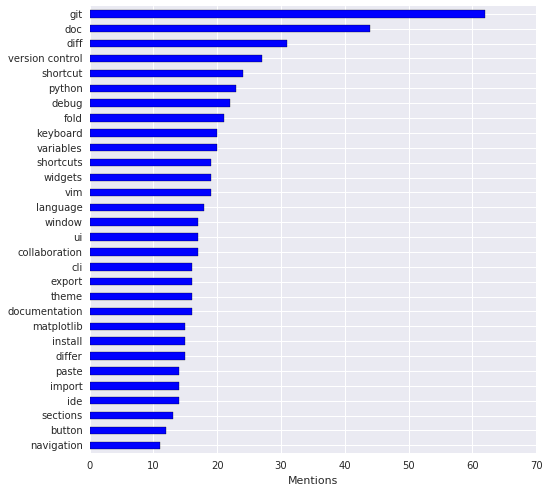

In [145]:
ax = hist[-30:].plot.barh(figsize=(8, 8))
_ = ax.set_xlabel('Mentions')